Transaction Table *

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38



In [1]:
import pandas as pd
import numpy as np
import gc
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 12, 10

In [ ]:
train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')

In [ ]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train = train.drop(columns=[x for x in train.columns if x.startswith("V")])
train.shape

In [ ]:
del train_identity, train_transaction
gc.collect()


In [ ]:
# move isFraud to end
isFraud = train['isFraud']
train.drop(labels=['isFraud'], axis=1, inplace = True)
train['isFraud'] = isFraud
del isFraud

# print amount of each
frauds = train.shape[0]
yes = train['isFraud'].sum()
no = frauds - yes
print('{} frauds'.format(frauds))
print('{} yes \n{} no'.format(yes,no))

In [ ]:
print(list(train.columns))


In [ ]:
train.to_pickle("train.pkl")

In [3]:
train = pd.read_pickle("train.pkl")

## add new column for same emails

In [4]:
train['is_email_same'] = train.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)

# Start to prepare Train for finding best models

## remove columns over 80% missing

In [5]:
columns_dropped = []

def remove_columns(perc_limit):
    missing_perc = (train.isna().sum() / train.isna().count()).sort_values(ascending=False)
    print("remove_columns limit:", perc_limit)
    print("missing perc (first 20):", dict(missing_perc[:20]))
    perc_too_high_cols = missing_perc[missing_perc > perc_limit].index
    print("Columns over the limit (first 20):",perc_too_high_cols[:20])
    print("before drop:", train.shape)
    columns_dropped.extend(perc_too_high_cols)
    train.drop(columns=perc_too_high_cols, inplace=True)
    print("after drop:", train.shape)
    
remove_columns(0.80)

remove_columns limit: 0.8
missing perc (first 20): {'id_24': 0.9919615944728554, 'id_25': 0.9913096487960172, 'id_08': 0.9912707013919464, 'id_07': 0.9912707013919464, 'id_21': 0.9912639279303688, 'id_26': 0.9912571544687913, 'id_22': 0.9912469942764249, 'id_23': 0.9912469942764249, 'id_27': 0.9912469942764249, 'dist2': 0.9362837403054831, 'D7': 0.9340992989467267, 'id_18': 0.9236072069631185, 'D13': 0.8950926270870728, 'D14': 0.8946946862193924, 'D12': 0.8904104717715988, 'id_03': 0.8876892335828225, 'id_04': 0.8876892335828225, 'D6': 0.8760676668811597, 'id_33': 0.8758949436109323, 'D8': 0.8731229044603245}
Columns over the limit (first 20): Index(['id_24', 'id_25', 'id_08', 'id_07', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_03', 'id_04',
       'D6', 'id_33', 'D8'],
      dtype='object')
before drop: (590540, 96)
after drop: (590540, 69)


## Remove too many NaN on rows

In [6]:
def drop_more_than_N_Nan(N): # of the 68 columns, only 12 allowed to be NaN
    print(train.shape)
    train.dropna(thresh=train.shape[1]-N, axis=0, inplace=True)
    print(train.shape)
    
drop_more_than_N_Nan(12)
print(train.shape, list(train.columns))

(590540, 69)
(11074, 69)
(11074, 69) ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'isFraud', 'is_email_same']


In [7]:
train.set_index("TransactionID", inplace=True)
train.shape, train.columns

((11074, 68),
 Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
        'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
        'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
        'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
        'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
        'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12',
        'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29',
        'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
        'isFraud', 'is_email_same'],
       dtype='object'))

## check categories

In [8]:
def check_categories():
    for col, values in train.loc[:, train.dtypes == object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 5:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.unique()[:20], "....")
            print ("")
            print (values.value_counts()[:10])
            print ('\n')
            
check_categories()

P_emaildomain: 46
['gmail.com' 'anonymous.com' 'hotmail.com' 'att.net' 'outlook.com'
 'servicios-ta.com' 'yahoo.com.mx' 'icloud.com' 'live.com.mx' 'msn.com'
 'aol.com' 'yahoo.com' 'verizon.net' 'web.de' 'yahoo.fr' 'hotmail.fr'
 'comcast.net' 'outlook.es' 'earthlink.net' 'prodigy.net.mx'] ....

gmail.com        4102
hotmail.com      3784
anonymous.com    1391
outlook.com       308
yahoo.com         294
yahoo.com.mx      214
aol.com           131
live.com.mx       127
live.com           76
outlook.es         64
Name: P_emaildomain, dtype: int64


R_emaildomain: 49
['gmail.com' 'anonymous.com' 'hotmail.com' 'att.net' 'outlook.com'
 'servicios-ta.com' 'yahoo.com.mx' nan 'icloud.com' 'live.com.mx'
 'msn.com' 'aol.com' 'yahoo.com' 'verizon.net' 'bellsouth.net' 'web.de'
 'yahoo.fr' 'hotmail.fr' 'comcast.net' 'outlook.es'] ....

gmail.com        4133
hotmail.com      3780
anonymous.com    1387
outlook.com       308
yahoo.com         279
yahoo.com.mx      214
live.com.mx       135
aol.com      

In [9]:
def get_perc(x):
    return x.sum()/x.count()

In [10]:
email_repl = ['gmail', 'hotmail', 'yahoo', 'aol', 'anonymous', 'outlook', 'protonmail',"nothing"]
DeviceInfo_repl = ['rv', 'windows', 'ios', 'build', 'trident', 'moto', "nothing"]
id_31_repl = ['icedragon', 'firefox', 'android', 'chrome', 'safari', 'ie', 'edge', 'samsung', 'opera',"nothing"]

In [11]:
train.loc[train['P_emaildomain'].isna(), 'P_emaildomain'] = "nothing"
for i in email_repl:
    train.loc[train['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
train.loc[~train['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

train.loc[train['R_emaildomain'].isna(), 'R_emaildomain'] = "nothing"
for i in email_repl:
    train.loc[train['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
train.loc[~train['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

train.loc[train['id_31'].isna(), 'id_31'] = "nothing"
for i in id_31_repl:
    train.loc[train['id_31'].str.contains(i), 'id_31'] = i
train.loc[~train['id_31'].isin(id_31_repl), 'id_31'] = "other"

train.loc[train['DeviceInfo'].isna(), 'DeviceInfo'] = "nothing"
for i in DeviceInfo_repl:
    train.loc[train['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
train.loc[~train['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
train['DeviceInfo'].value_counts().head(15)

other      10541
rv           309
nothing      212
moto          12
Name: DeviceInfo, dtype: int64

## again remove empty columns

In [12]:
remove_columns(0.80)
print("columns_dropped:",columns_dropped)

remove_columns limit: 0.8
missing perc (first 20): {'D11': 1.0, 'dist1': 1.0, 'M5': 1.0, 'M3': 1.0, 'M2': 1.0, 'M1': 1.0, 'M8': 1.0, 'M9': 1.0, 'M7': 1.0, 'M6': 1.0, 'addr2': 0.8166877370417194, 'addr1': 0.8166877370417194, 'M4': 0.10502076936969477, 'D3': 0.04117753296008669, 'D2': 0.03955210402745169, 'D10': 0.017518511829510565, 'D15': 0.008849557522123894, 'D5': 0.007946541448437781, 'id_16': 0.005598699656853892, 'id_13': 0.0027090482210583348}
Columns over the limit (first 20): Index(['D11', 'dist1', 'M5', 'M3', 'M2', 'M1', 'M8', 'M9', 'M7', 'M6', 'addr2',
       'addr1'],
      dtype='object')
before drop: (11074, 68)
after drop: (11074, 56)
columns_dropped: ['id_24', 'id_25', 'id_08', 'id_07', 'id_21', 'id_26', 'id_22', 'id_23', 'id_27', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_03', 'id_04', 'D6', 'id_33', 'D8', 'id_09', 'id_10', 'D9', 'id_30', 'id_32', 'id_34', 'id_14', 'D11', 'dist1', 'M5', 'M3', 'M2', 'M1', 'M8', 'M9', 'M7', 'M6', 'addr2', 'addr1']


In [13]:
def missing_vals(df):
    x = []
    for col in df.columns:
        vals = df[col].value_counts().shape[0]
        missing = round((df[col].isna().sum()/df[col].shape[0])*100,2)
        x.append([col,vals,missing])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd.DataFrame(x, columns=["col","vals","missing"]).set_index("col"))

missing_vals(train)

                 vals  missing
col                           
TransactionDT   11070     0.00
TransactionAmt   2895     0.00
ProductCD           3     0.00
card1            1031     0.00
card2             164     0.01
card3              54     0.00
card4               4     0.00
card5              44     0.02
card6               3     0.00
P_emaildomain       7     0.00
R_emaildomain       8     0.00
C1                108     0.00
C2                165     0.00
C3                  1     0.00
C4                 70     0.00
C5                  1     0.00
C6                 69     0.00
C7                 59     0.00
C8                 79     0.00
C9                  1     0.00
C10                84     0.00
C11                98     0.00
C12                91     0.00
C13               105     0.00
C14                48     0.00
D1                600     0.00
D2                598     3.96
D3                464     4.12
D4                711     0.00
D5                463     0.79
D10     

In [14]:
# remove columns with only 1 values and not missing
# train = pd.read_pickle("trainbeforeScale.pkl")
cols_remove = train.columns[train.apply(lambda x: x.value_counts().shape[0]) == 1]
columns_dropped.extend(cols_remove)
train.drop(columns=cols_remove, inplace=True)
print("removed:", cols_remove)

removed: Index(['C3', 'C5', 'C9'], dtype='object')


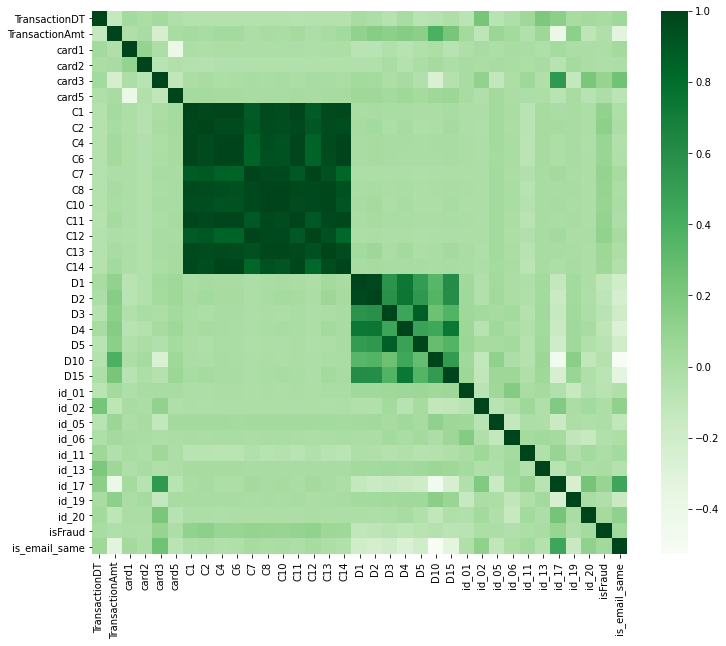

In [15]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=False, cmap="Greens")
plt.show()

In [16]:
train.to_pickle("trainbeforeScale.pkl")
train.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D15', 'M4', 'id_01', 'id_02',
       'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17',
       'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37',
       'id_38', 'DeviceType', 'DeviceInfo', 'isFraud', 'is_email_same'],
      dtype='object')

# scale everything

In [17]:
num_cols_mask = (train.dtypes != object) & (train.columns != 'isFraud') & (train.nunique()>2)
not_num_cols_mask = (train.dtypes == object)
num_cols = train.columns[num_cols_mask]
not_num_cols = train.columns[not_num_cols_mask]

In [18]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

# remove outliers and fill missing

In [19]:
print(train.shape)
imp_kNN = KNNImputer(missing_values = np.nan)
imp_kNN.fit(train[num_cols])
train[num_cols] = imp_kNN.transform(train[num_cols])
print(train.shape)

(11074, 53)
(11074, 53)


In [20]:
check_categories()

P_emaildomain: 7
['gmail' 'anonymous' 'hotmail' 'other' 'outlook' 'yahoo' 'aol'] ....

gmail        4125
hotmail      3883
anonymous    1391
other         592
yahoo         580
outlook       372
aol           131
Name: P_emaildomain, dtype: int64


R_emaildomain: 8
['gmail' 'anonymous' 'hotmail' 'other' 'outlook' 'yahoo' 'nothing' 'aol'] ....

gmail        4156
hotmail      3879
anonymous    1387
other         589
yahoo         567
outlook       372
aol           117
nothing         7
Name: R_emaildomain, dtype: int64


id_31: 9
['chrome' 'android' 'edge' 'samsung' 'firefox' 'ie' 'safari' 'opera'
 'other'] ....

chrome     4801
android    3834
firefox     615
ie          597
samsung     391
safari      368
edge        304
other       136
opera        28
Name: id_31, dtype: int64




## replace the last few NaN for the models

In [21]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(train[not_num_cols])
train[not_num_cols] = imp.transform(train[not_num_cols])

In [22]:
train.to_pickle("train_beforeOneHotEncoder.pkl")
# train = pd.read_pickle("train_beforeOneHotEncoder.pkl")
print(train.shape)

(11074, 53)


In [23]:
train_hot_categories = {}
def onehot(df, col, categories=None):
    print("using", col, categories)
    print("unique values:", df[col].unique().tolist())
    if categories:
        enc = OneHotEncoder(sparse=False, categories=(categories,), handle_unknown="ignore")
    else:
        enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
    array_hot_encoded = enc.fit_transform(df[[col]])
    print("get_feature_names:", enc.get_feature_names([col]))
    print("categories_:", enc.categories_)
    train_hot_categories[col] = list(enc.categories_[0])
    hot_array = pd.DataFrame(array_hot_encoded, columns=enc.get_feature_names([col]))
    print("hot_array.columns", hot_array.columns)
    return pd.concat([df.drop(columns=[col]).reset_index(drop=True), hot_array], axis=1)

In [24]:
train.reset_index(inplace=True)
for col in not_num_cols:
    cates = train[col].unique().tolist()
    train = onehot(df=train, col=col, categories=cates)

using ProductCD ['C', 'R', 'H']
unique values: ['C', 'R', 'H']
get_feature_names: ['ProductCD_C' 'ProductCD_R' 'ProductCD_H']
categories_: [array(['C', 'R', 'H'], dtype=object)]
hot_array.columns Index(['ProductCD_C', 'ProductCD_R', 'ProductCD_H'], dtype='object')
using card4 ['mastercard', 'visa', 'american express', 'discover']
unique values: ['mastercard', 'visa', 'american express', 'discover']
get_feature_names: ['card4_mastercard' 'card4_visa' 'card4_american express' 'card4_discover']
categories_: [array(['mastercard', 'visa', 'american express', 'discover'], dtype=object)]
hot_array.columns Index(['card4_mastercard', 'card4_visa', 'card4_american express',
       'card4_discover'],
      dtype='object')
using card6 ['credit', 'debit', 'charge card']
unique values: ['credit', 'debit', 'charge card']
get_feature_names: ['card6_credit' 'card6_debit' 'card6_charge card']
categories_: [array(['credit', 'debit', 'charge card'], dtype=object)]
hot_array.columns Index(['card6_credit', 

In [25]:
train.set_index("TransactionID", inplace=True)

In [26]:
train.to_pickle("train_beforeKNeighborsClassifier.pkl")
print(train.shape)

(11074, 97)


In [27]:
y = train['isFraud']   #target classes
X = train.drop('isFraud', axis=1)
y

TransactionID
2987010    0
2987130    0
2987252    0
2987258    0
2987328    0
          ..
3577365    0
3577469    0
3577486    0
3577499    0
3577521    0
Name: isFraud, Length: 11074, dtype: int64

In [28]:
kNN = KNeighborsClassifier(n_neighbors=3)  
kNN_scores = cross_val_score(kNN, X, y, cv=5)
print("5x CV Accuracy kNNs: {0:.2f}".format(kNN_scores.mean())) 
kNN_scores


5x CV Accuracy kNNs: 0.94


array([0.94176072, 0.93589165, 0.93950339, 0.93634312, 0.93179765])

# Now for Test

In [29]:
test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')

In [30]:
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
test = test.drop(columns=[x for x in test.columns if x.startswith("V")])
test.shape

(506691, 94)

In [31]:
del test_identity, test_transaction
gc.collect()

8207

### need to set value for the test set

In [32]:
test["isFraud"] = "test"

In [33]:
test.columns=test.columns.str.replace('-','_')

In [34]:
print(list(test.columns))
test.to_pickle("test.pkl")

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'isFraud']


In [35]:
print("dropping these:", columns_dropped)
print(test.shape)
test.drop(columns=columns_dropped, inplace=True)
print(test.shape)

dropping these: ['id_24', 'id_25', 'id_08', 'id_07', 'id_21', 'id_26', 'id_22', 'id_23', 'id_27', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_03', 'id_04', 'D6', 'id_33', 'D8', 'id_09', 'id_10', 'D9', 'id_30', 'id_32', 'id_34', 'id_14', 'D11', 'dist1', 'M5', 'M3', 'M2', 'M1', 'M8', 'M9', 'M7', 'M6', 'addr2', 'addr1', 'C3', 'C5', 'C9']
(506691, 95)
(506691, 53)


In [36]:
test['is_email_same'] = test.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)

In [37]:
test.loc[test['P_emaildomain'].isna(), 'P_emaildomain'] = "nothing"
for i in email_repl:
    test.loc[test['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
test.loc[~test['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

test.loc[test['R_emaildomain'].isna(), 'R_emaildomain'] = "nothing"
for i in email_repl:
    test.loc[test['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
test.loc[~test['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

test.loc[test['id_31'].isna(), 'id_31'] = "nothing"
for i in id_31_repl:
    test.loc[test['id_31'].str.contains(i), 'id_31'] = i
test.loc[~test['id_31'].isin(id_31_repl), 'id_31'] = "other"

test.loc[test['DeviceInfo'].isna(), 'DeviceInfo'] = "nothing"
for i in DeviceInfo_repl:
    test.loc[test['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
test.loc[~test['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
test['DeviceInfo'].value_counts().head(15)

nothing    391634
other      110902
rv           2812
moto         1343
Name: DeviceInfo, dtype: int64

In [38]:
imp = SimpleImputer(strategy='constant', fill_value='missing')
imp.fit(test[not_num_cols])
test[not_num_cols] = imp.transform(test[not_num_cols])

In [39]:
train_hot_categories

{'ProductCD': ['C', 'R', 'H'],
 'card4': ['mastercard', 'visa', 'american express', 'discover'],
 'card6': ['credit', 'debit', 'charge card'],
 'P_emaildomain': ['gmail',
  'anonymous',
  'hotmail',
  'other',
  'outlook',
  'yahoo',
  'aol'],
 'R_emaildomain': ['gmail',
  'anonymous',
  'hotmail',
  'other',
  'outlook',
  'yahoo',
  'nothing',
  'aol'],
 'M4': ['M0', 'M2', 'M1'],
 'id_12': ['NotFound', 'Found'],
 'id_15': ['Found', 'New', 'Unknown'],
 'id_16': ['Found', 'NotFound'],
 'id_28': ['Found', 'New'],
 'id_29': ['Found', 'NotFound'],
 'id_31': ['chrome',
  'android',
  'edge',
  'samsung',
  'firefox',
  'ie',
  'safari',
  'opera',
  'other'],
 'id_35': ['F', 'T'],
 'id_36': ['F', 'T'],
 'id_37': ['T', 'F'],
 'id_38': ['T', 'F'],
 'DeviceType': ['desktop', 'mobile'],
 'DeviceInfo': ['other', 'nothing', 'rv', 'moto']}

In [40]:
test.reset_index(inplace=True)
for col in not_num_cols:
    test = onehot(df=test, col=str(col), categories=train_hot_categories[col])


using ProductCD ['C', 'R', 'H']
unique values: ['W', 'C', 'S', 'H', 'R']
get_feature_names: ['ProductCD_C' 'ProductCD_R' 'ProductCD_H']
categories_: [array(['C', 'R', 'H'], dtype=object)]
hot_array.columns Index(['ProductCD_C', 'ProductCD_R', 'ProductCD_H'], dtype='object')
using card4 ['mastercard', 'visa', 'american express', 'discover']
unique values: ['visa', 'mastercard', 'american express', 'discover', 'missing']
get_feature_names: ['card4_mastercard' 'card4_visa' 'card4_american express' 'card4_discover']
categories_: [array(['mastercard', 'visa', 'american express', 'discover'], dtype=object)]
hot_array.columns Index(['card4_mastercard', 'card4_visa', 'card4_american express',
       'card4_discover'],
      dtype='object')
using card6 ['credit', 'debit', 'charge card']
unique values: ['debit', 'credit', 'missing', 'charge card']
get_feature_names: ['card6_credit' 'card6_debit' 'card6_charge card']
categories_: [array(['credit', 'debit', 'charge card'], dtype=object)]
hot_array

In [47]:
test.set_index("TransactionID", inplace=True)
test.drop(columns="index", inplace=True)

In [48]:
list(test.columns) == list(train.columns)

True

In [49]:
list(set(list(test.columns)) - set(list(train.columns)))

[]

In [45]:
list(test.columns)

['index',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'C1',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D15',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_13',
 'id_17',
 'id_19',
 'id_20',
 'isFraud',
 'is_email_same',
 'ProductCD_C',
 'ProductCD_R',
 'ProductCD_H',
 'card4_mastercard',
 'card4_visa',
 'card4_american express',
 'card4_discover',
 'card6_credit',
 'card6_debit',
 'card6_charge card',
 'P_emaildomain_gmail',
 'P_emaildomain_anonymous',
 'P_emaildomain_hotmail',
 'P_emaildomain_other',
 'P_emaildomain_outlook',
 'P_emaildomain_yahoo',
 'P_emaildomain_aol',
 'R_emaildomain_gmail',
 'R_emaildomain_anonymous',
 'R_emaildomain_hotmail',
 'R_emaildomain_other',
 'R_emaildomain_outlook',
 'R_emaildomain_yahoo',
 'R_emaildomain_nothing',
 'R_emaildomain_aol',
 'M4_M0',
 'M4_M2',
 'M4_M1',
 'id_12_NotFound',
 'id_12_Found',
 'id_15_Found',
 'id_15_New',
 'id_1

In [44]:
list(train.columns)

['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'C1',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D15',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_13',
 'id_17',
 'id_19',
 'id_20',
 'isFraud',
 'is_email_same',
 'ProductCD_C',
 'ProductCD_R',
 'ProductCD_H',
 'card4_mastercard',
 'card4_visa',
 'card4_american express',
 'card4_discover',
 'card6_credit',
 'card6_debit',
 'card6_charge card',
 'P_emaildomain_gmail',
 'P_emaildomain_anonymous',
 'P_emaildomain_hotmail',
 'P_emaildomain_other',
 'P_emaildomain_outlook',
 'P_emaildomain_yahoo',
 'P_emaildomain_aol',
 'R_emaildomain_gmail',
 'R_emaildomain_anonymous',
 'R_emaildomain_hotmail',
 'R_emaildomain_other',
 'R_emaildomain_outlook',
 'R_emaildomain_yahoo',
 'R_emaildomain_nothing',
 'R_emaildomain_aol',
 'M4_M0',
 'M4_M2',
 'M4_M1',
 'id_12_NotFound',
 'id_12_Found',
 'id_15_Found',
 'id_15_New',
 'id_15_Unknown'